## <a class="anchor" id="main_info"></a>Main information
>Packages used throughout the whole notebook:
>* plotly
>* selenium
>* bs4
>* undetected_chromedriver
>* statsmodels
>* pmdarima
>* prophet
>* seaborn

In [ ]:
# !pip install plotly, selenium, bs4, undetected_chromedriver, statsmodels, pmdarima, fbprophet, seaborn

## <a class="anchor" id="extraction"></a>1. Data extraction
- In more informal and rather illegal terms, **Scraping**
>Based on Selenium, and thanks to the Steam database, I've used undetected_chromedriver as a way to bypass the captchas and human verification in order to get the data, and again, for educational purposes only.
<br><br>
>The data is going to be scrutinized on multiple levels, with some EDA, in order to come up with a good machine learning problem and an appropriate context/frame work for this project.
<br><br>
>This notebook will include some gibberish of course, no clean version intended in order to keep a complete lucidity and transluscency of every step taken throughout the project.
>><p style="color:red">Do not run this code unless you're willing to risk having your IP temporarily banned by Steam or if you're using a VPN.</p>
##### Credits:
- <a href="https://steamdb.info/"><i>The Steam Database used to acquire the data.</i></a>

#### <b id="imports">Main imports</b>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from time import sleep

# # If no captcha...
# from selenium.webdriver import Chrome # For chrome
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select

# To bypass captcha verification & get HTML body
import undetected_chromedriver as uc
from bs4 import BeautifulSoup

#### Setup browser

In [ ]:
# Open the browser
options = webdriver.ChromeOptions()
options.add_extension('extension_4_43_0_0.crx')
driver = uc.Chrome()

#### <b id="Sales extraction">Sales extraction</b>

In [ ]:
sleep(1)
driver.switch_to.window(driver.window_handles[0])
driver.get("https://steamdb.info/sales/")
sleep(2)

In [ ]:
# Set to view all
select = Select(driver.find_element(By.XPATH, '//*[@id="DataTables_Table_0_length"]/label/select'))
select.select_by_value('-1')

In [ ]:
# Fetch table with bs4
html=driver.page_source
soup=BeautifulSoup(html,'html.parser')
# Fetch table with pandas
table=pd.read_html(str(soup.select_one('table#DataTables_Table_0')))

In [ ]:
# Creating and cleaning the dataframe
price_rating_df = table[0][['Name','%','Price','Rating','Release']].rename(columns={'Name':'game','Price':'price','Rating':'rating','Release':'month_release'})
price_rating_df['%'] = price_rating_df['%'].str.replace('%', '').astype(int) * -1
price_rating_df['price'] = price_rating_df['price'].str.replace('$','').astype(float)
price_rating_df['rating'] = price_rating_df['rating'].str.replace('%','').astype(float)
price_rating_df['price_before_discount'] = ((price_rating_df.price * 100)/(100 - price_rating_df['%'])).round(2)
price_rating_df['game'] = price_rating_df.game.str.replace(r"(all-time[A-Za-z0-9\t .:$]+)", '', regex=True)
price_rating_df.head()

In [ ]:
# # Export to csv file for local use and avoid re-scraping
# price_rating_df.to_csv('price_rating.csv', index=False)

#### <b>Users extraction</b>

In [ ]:
# For the number of users
driver.get("https://steamdb.info/graph/")
sleep(1)

# Set to view all
select = Select(driver.find_element(By.XPATH, '//*[@id="table-apps_length"]/label/select'))
select.select_by_value('-1')

# Fetch table with bs4
html=driver.page_source
soup=BeautifulSoup(html,'html.parser')
# Fetch table with pandas
table=pd.read_html(str(soup.select_one('table#table-apps')))

In [ ]:
# Create dataframe
users_df = table[0][['Name','Current','24h Peak','All-Time Peak']].rename(columns={'Name':'game','Current':'current','24h Peak':'24h','All-Time Peak':'all_time'})
users_df['game'] = users_df.game.str.replace(r"(all-time[A-Za-z0-9\t .:$]+)", '', regex=True)

users_df.head()

In [ ]:
# # Export to csv file for local use
# users_df.to_csv('users.csv', index=False)

In [ ]:
# Create a main dataframe to merge on the name of the game
df_sales = pd.read_csv('price_rating.csv')
df_users = pd.read_csv('users.csv')
df = df_users.merge(df_sales, on='game',how='left').dropna(subset=['rating','price'])
print(f'Only {df.shape[0]} out of {df_users.shape[0]} games left after merging the two dataframes, forming this dataframe below:')
df

In [ ]:
df.corr().style.background_gradient()

#### <b>Formulating a ML problem</b>

<b>With the data at hand, it's rather difficult to find correlations, however, TIME SERIES sounds like a good an option for starters.</b>
* First, the data is very limited to only 792 game with no NaN values on the important columns.
* The final dataframe groups together the price of games and the discount, as well as ratings, which are very important for the dataframe in order to come up with a good model.
* Based on only the two separate dataframes, it is hard to make a predicting model.
* Finally, in the final dataframe (grouping the two dataframes) the correlations are only noticeable in each section, i.e each dataframe respectively

#### Thus, the dataset analyzed on the level of the month column, for the sales data separately because it represents the most number of records, for the purpose of coming up with a good <b>time series model.</b>
> Multiple packages will be used for this analysis, such as statsmodels for the Arima algorithm, pmdarima, and FBProphet.<br><br>
> <i>One thing to note is that the data is monthly only because the extracted data is limited as such.</i> Which may (or may not) prove to be challenging for the time series analysis.

## 2. Time Series Exploratory Data Analysis

### <b>Main Timeseries data initiation</b>

In [ ]:
from time import strptime

# Main sales dataframe copy
df = df_sales.copy()

# Cleaning the sales data and dropping unwanted data
df[['month','year']] = pd.DataFrame(df.month_release.str.split(' ').tolist(), index=df.index)
df = df.drop(df[df['month'] == '—'].index)

# Get the month and make a date column
df['date'] = pd.to_datetime(df['month_release'].map(lambda x: str(strptime(x.split(' ')[0],'%b').tm_mon) + '-' + x.split(' ')[1])).dt.date
df = df.sort_values('date').drop(columns=['month','year','month_release'])
df = df.groupby('date').agg({'game':'count','price':'mean','rating':'mean','price_before_discount':'mean'})
df

In [ ]:
fig = px.line(df, y=['rating','price','game'], title=f'Number of games, average rating and price throughout the period from <b>{df.index.min()}</b> to <b>{df.index.max()}</b>')
fig.show()

In [ ]:
fig = px.line(df, y=['price','price_before_discount'], title=f'<b>Price, Rating, and Price before discount through time.</b><br>It is clear that the price and price_before_discount are well correlated. They follow the same pattern.')
fig.show()

### <b>Stationarity test</b>

In [ ]:
from statsmodels.tsa.stattools import adfuller
def get_stationarity(timeseries, col):
    
    # rolling statistics
    rolling_mean = timeseries[col].rolling(window=12).mean()
    rolling_std = timeseries[col].rolling(window=12).std()
    
    # rolling statistics plot
    plt.figure(figsize=(11,3))
    original = plt.plot(timeseries[col], color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title(fr'Rolling Mean & Standard Deviation of the column: {col.upper()}')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries[col])
    print('ADF Statistic: {}'.format(result[0]))
    print("\033[1m" + 'p-value: {}'.format(result[1]) + "\033[0m")
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

get_stationarity(df, 'game'),get_stationarity(df, 'rating'),get_stationarity(df, 'price'),get_stationarity(df, 'price_before_discount')

>None of the values (price, rating, price_before_discount, N° of games) is stationary based on the ADFuller test's p-value.<br>
>I will opt for the use of Prophet which provides an in-depth and more optimized set of tools for time series data.<br><br>
>But first... 
#### <b>I've decided to go with a more robust and rich dataset with greatly granular data in terms of date values, which would prove to be very handy for our time series analysis.<br></b>
This time only based on the ratings of the users, as well as Metacritic's score. Courtesy to: <b><a href="https://www.kaggle.com/datasets/deepcontractor/top-video-games-19952021-metacritic">this kaggle post</a></b>.

In [7]:
# Main secondary time series dataframe
df2 = pd.read_csv('all_games.csv')
df2['release_date'] = pd.to_datetime(df2.release_date).dt.date
df2 = df2.sort_values('release_date')
# Keep only rows in which user_review is a number (between 1000 and 2000 rows removed), then change the type to float --- *10 in order to normalize it with that of meta_score
df2 = df2[df2.user_review.str.contains(r'\d', regex=True)].rename(columns={'release_date':'date'})
df2['user_review'] = (df2.user_review.astype(float) * 10).astype(int)

df2.head()

,name,platform,date,summary,meta_score,user_review
1437,Full Throttle,PC,1995-04-30,"You're Ben--beaten, framed for murder and left...",86,86
653,Duke Nukem 3D,PC,1996-01-29,Prepare yourself for the ultimate 3D Slugfest....,89,87
88,Sid Meier's Civilization II,PC,1996-02-29,An empire-building turn-based strategy game. T...,94,88
8121,Bad Mojo,PC,1996-02-29,Roger was about to do something bad. Unfortuna...,74,69
350,Resident Evil,PlayStation,1996-03-30,Raccoon City has been completely overrun by mu...,91,91


#### <b>EDA - Second Time Series</b>

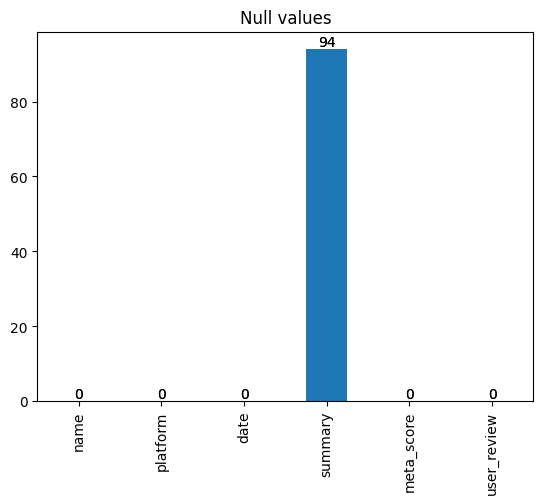

In [8]:
# # Checking the data and finding out the null values
# df2.info()
# df2.describe()
ax = df2.isna().sum().plot(kind='bar', title='Null values')
ax.bar_label(ax.containers[0])
for container in ax.containers:
    ax.bar_label(container)

In [9]:
fig = px.bar(df2.groupby(['platform']).agg({'name':'count','user_review':'mean','meta_score':'mean'}).reset_index(), x='platform',y=['name'], width=1300, height=800, text='platform', color='platform')
fig.update_layout(title_text=f'Number of games reviewed by platform between {df2.date.min()} and {df2.date.max()}', title_x=0.5)
fig.show()

In [10]:
fig = px.box(df2,y=['user_review','meta_score'], width=700)
fig.update_layout(title_text=f'Distribution of scores between {df2.date.min()} and {df2.date.max()}', title_x=0.5)
fig.show()

#### Based on the above:
> 1. In the first graph above, the distribution is rather disproportionate, where the PC dominates all the number of games reviewed, whereas consoles of all type reside farther from it, aside from last gen games such as Switch, XBOX 360, XO, PS4, PS3 and PS2.
<br>
> 2. We note that common people's reviews almost identical to that of Metacritic's score. However, the outliers on the user_review are more important.
<br>
##### Can we come up with a good time series forecasting model for forecasting the reviews in the next few days/weeks?

In [11]:
# Main Timeseries dataframe - Focus only on games starting from 2000-01-01
main_df = df2.copy().groupby(['date']).agg({'name':'count','user_review':'mean','meta_score':'mean'}).reset_index()
main_df = main_df[main_df.date > pd.to_datetime('2000-05-01')]

fig = px.line(main_df, x='date', y=['meta_score', 'user_review'], title='Evolution of reviews through time')
fig.show()

C:\Users\Zakaria Tahiri\AppData\Local\Temp\ipykernel_16276\168708092.py:3: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



### <b>FBProphet</b>


In [12]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

user_df = main_df.copy()[['date','user_review']].rename(columns={'date':'ds','user_review':'y'})
meta_df = main_df.copy()[['date','meta_score']].rename(columns={'date':'ds','meta_score':'y'})
meta_df.head()

c:\Users\Zakaria Tahiri\.pyenv\pyenv-win\versions\3.9.0\lib\site-packages\tqdm\auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



,ds,y
102,2000-05-15,92.0
103,2000-05-16,77.0
104,2000-05-22,97.0
105,2000-05-31,81.0
106,2000-06-01,86.0


<b>Stationarity test</b><br>
The p-value is significant enough to reject the null hypothesis for both, user data and metacritic data

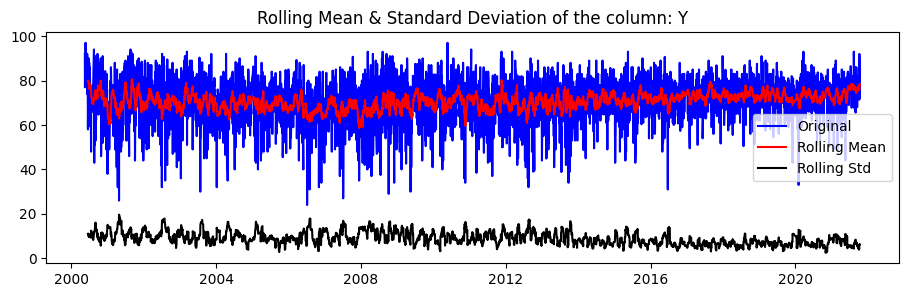

ADF Statistic: -9.170022635845887
p-value: 2.402326096930625e-15
Critical Values:
	1%: -3.4318787911913216
	5%: -2.8622155353827377
	10%: -2.5671295925954234


In [13]:
from statsmodels.tsa.stattools import adfuller
def get_stationarity(timeseries, col):
    timeseries = timeseries.set_index('ds')
    
    # rolling statistics
    rolling_mean = timeseries[col].rolling(window=12).mean()
    rolling_std = timeseries[col].rolling(window=12).std()
    
    # rolling statistics plot
    plt.figure(figsize=(11,3))
    original = plt.plot(timeseries[col], color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title(fr'Rolling Mean & Standard Deviation of the column: {col.upper()}')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries[col])
    print('ADF Statistic: {}'.format(result[0]))
    print("\033[1m" + 'p-value: {}'.format(result[1]) + "\033[0m")
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

get_stationarity(meta_df, 'y')

In [14]:
# Train test split
from sklearn.model_selection import train_test_split
train, test = train_test_split(user_df, random_state=10, shuffle=False, test_size=.2)

threshold_date = pd.to_datetime(test.ds.min())



In [15]:
# Days to predict:
from datetime import timedelta, date

days_to_predict = 100

EndDate = date.today() + timedelta(days=days_to_predict)
pd.to_datetime(EndDate)


Timestamp('2023-04-11 00:00:00')

#### Model creation & forecasting

In [20]:
def build_model():
    """Define forecasting model."""
    
    model = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=True,
        daily_seasonality=False, 
        interval_width=0.95, 
        mcmc_samples = 500
    )

    model.add_seasonality(
        name='monthly', 
        period=30.5, 
        fourier_order=5 # 5 for monthly
    )
    return model
    
m = build_model()
m.fit(train)
# future = m.make_future_dataframe(periods=days_to_predict) # int(np.round(test.shape[0] * 1)
# forecast = m.predict(future)

19:43:35 - cmdstanpy - INFO - CmdStan installation c:\Users\Zakaria Tahiri\.pyenv\pyenv-win\versions\3.9.0\lib\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
19:43:35 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
19:43:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




In [ ]:
# Forecasting
future = m.make_future_dataframe(periods=test.shape[0], freq='D')

forecast = m.predict(df=future)


In [ ]:
plot1 = plot_plotly(m,forecast)
plot1

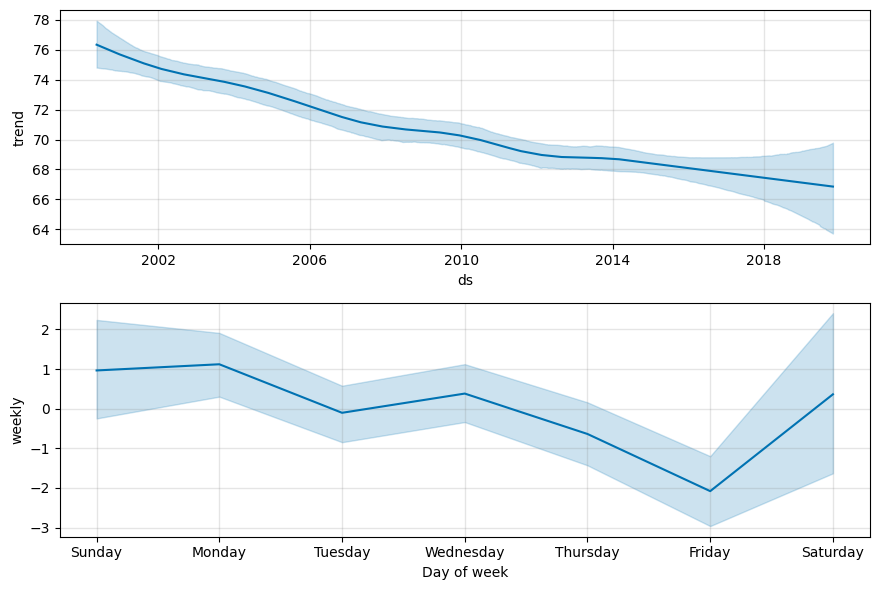

In [ ]:
plot2 = m.plot_components(forecast)
